In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import ROOT
import pickle
from scipy import interpolate

import tb2024 as tb

dfmain={} # top level event data structure, containg sub-structure
#  (per event)   df_ev
#  (event info)  dfinfo, 
#  (simhit)  dfCshit2D, dfCshit3D, dfSshit2D, dfSshit3D  [chID, val] - pulse train from G4
#  (digihit) dfCdhit2D, dfCdhit3D, dfSdhit2D, dfSdhit3D  [chID, val] - simulated waveform
#  (rechit)  dfCrhit2D, dfCrhit3D, dfSrhit2D, dfSrhit3D  [chID, val] - reconstructed pulse train

#  (per event)   event 
#  (simhit) 　simhit2dC, simhit2dS, simhit3dC, simhit3dS   - pulse train from G4
#  (waaveform) waveform2dC, waveform2dS, waveform3dC, waveform3dS - convoluted waveform
#  (rechit)  rechit2dC, rechit2dS, rechit3dC, rechit3dS   - reconstructed pulse train
#
#  event={eventID, }
#  simhit   = {chID, vals}
#  waveform = {chID, vals}
#  rechit   = {chID, vals}
#  chID=ix*1000000+iy*1000+it   (it:  50 ps or 200 ps slice)
#  chID=ix*1000000+iy*1000+iz   (iz:  2cm slicd? for dfCrhit3Dz in case of z-slice in MC)

ok=tb.test()  #  test to make sure the library tb2024 is loaded.
if ok>0:
    print("The library tb2024 is loaded sucessfully,  return code=",ok)

#
h1d={}   # for root histograming
h2d={}   # for root histograming (inteded for 2d histograms, but h1d may be used for 2d as well

maxEvents=2    # number of events to process
calibSS=1.0    # edep2GeV factor for scintillation signal (actual value from input nutple file)
calibCC=1.0    # ph2GeV factor for Cherenkov signal  (actual value from input nutple file)

fout=ROOT.TFile.Open("hgdream3dAnalysis.root","recreate")

Welcome to JupyROOT 6.30/04
print out in tb2024/test
The library tb2024 is loaded sucessfully,  return code= 1


In [2]:
class ntupleList:
    def __init__(self):
        self.files={}
        self.trees={}
        self.keys=[]
        self.indir="/Users/kunori/skdir/CaloX/dream2.05pre02/sim/build01/"
        # self.files["pi+100"]= ROOT.TFile.Open(self.indir+"mc_testjob_run002_001_Test_100evt_pi+_100.0_100.0.root")
        # self.files["e+100"]= ROOT.TFile.Open(self.indir+"mc_testjob_run001_001_Test_100evt_e+_100.0_100.0.root")
        self.files["pi+100"]= ROOT.TFile.Open(self.indir+"mc_testjob_run002_001_Test_10evt_pi+_100.0_100.0.root")
        self.files["e+100"]= ROOT.TFile.Open(self.indir+"mc_testjob_run001_001_Test_10evt_e+_100.0_100.0.root")
        print(type(self.files))

        for key in self.files.keys():
            # print("key=",key)
            self.keys.append(key)
            self.trees[key]=self.files[key].Get("tree")
            
        print("class ntupleList- keys")
        print(self.keys)
        
    
    def getKeys(self):
        return self.keys
    
    def getList(self):
        return self.files
    
    def getTrees(self):
        return self.trees
        

In [3]:
#  load pulse shapes from pkl file 
#  pkl files are originally in skmac20:/Users/kunori/skdir/CaloX/dream1.02/plotter
#  and copied to current directory.

rng = np.random.default_rng()

dfPulseShape=tb.getPulseShapeFromPkl("pulsedata_1033.pkl")


(def getPulseShapeFromPkl)  fname=  pulsedata_1033.pkl
Using run:  1033
number of pulses (events):  943
chlist: [1, 3, 6, 9]


(def plotPulseShape) type(df <class 'dict'>
run:  1033
number of events:  943
chlist: [1, 3, 6, 9]
ch  1    1mm_fast
ch  3    3mm_fast
ch  6    6mm_fast
ch  9    1mm_fast2


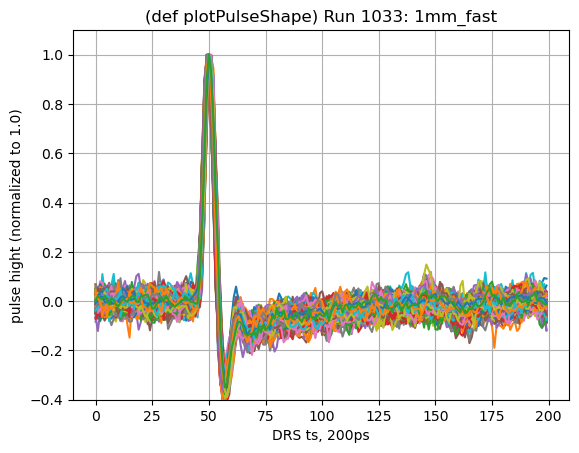

In [4]:
# show pulse data in pickl file
tb.plotPulseShape(dfPulseShape)

(def get_splwave) creating a set of single photon pulse shape with 
spline fits to measured pulse shapes in the pulse shape library from pkl file.
Example of a pulse shape from spline fit.
40 ns wide,  5 ps step.  Total 8000 steps.
ysum= 1.7092044683077177   ysum2= 237.2925828295545  ysum3  -235.58337836124682   ysum2+ysum3 1.7092044683076892


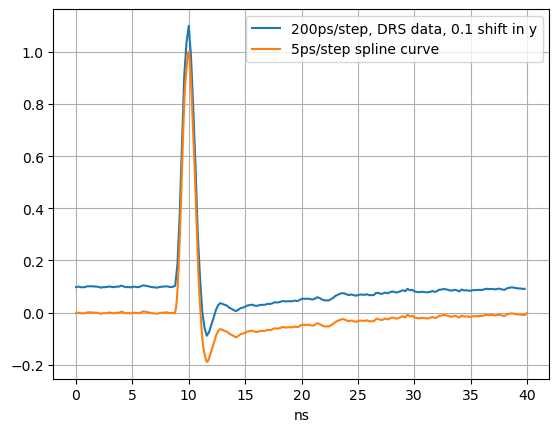

The number of spline wave is  943 . 
Each wave is a numpy array of  8000  long with  0.005  ps step. max at  39.995


In [5]:
#  get spline waveform.
n_splwave,splwave,timeslices=tb.get_splwave(dfPulseShape)
print("The number of spline wave is ",n_splwave,". ")
print("Each wave is a numpy array of ",len(splwave[2])," long with ",timeslices[1]-timeslices[0]," ps step. max at ",timeslices[-1]) 

In [6]:
def analyze2d(name,ix,iy,ph,calib):
    sum=np.sum(ph)
    
    k=np.argmax(ph)
    s="(def analyze2d)  2dmax {} ix {:6d}  iy {:5d} ph {:.2f}  en {:.2f}  sum {:.2f}, {:.2f} GeV" \
    .format(name,ix[k],iy[k],float(ph[k]),float(ph[k])*calib,sum,sum*calib)
    print(s)

    arg=np.argsort(-ph)
    for j, ja in enumerate(arg):
        if j>10:
            break
        s=" 2d k {:3d}  (ix,iy)  ({:3d}, {:3d})  ph {:.2f}  en {:.2f} GeV ".format(j,ix[ja],iy[ja],ph[ja],ph[ja]*calib)
        print(s)
       
    return ix[k],iy[k]
    

In [7]:
def analyze3d(name,ix,iy,it,ph,calib):
    sum=np.sum(ph)
    
    k=np.argmax(ph)
    s="(analyze3d)  3dmax {} ix {:6d}  iy {:5d} it {:5d}  ph {:.2f}  en {:.2f}  sum {:.2f}, {:.2f} GeV" \
    .format(name,ix[k],iy[k],it[k],float(ph[k]),float(ph[k])*calib,sum,sum*calib)
    print(s)

    arg=np.argsort(-ph)
    for j, ja in enumerate(arg):
        if j>10:
            break
        s=" 3d k {:3d}  (ix,iy,it)  ({:3d}, {:3d} {:4d})  ph {:.2f}  en {:.2f} GeV".format(j,ix[ja],iy[ja],it[ja],ph[ja],ph[ja]*calib)
        print(s)

    val = {}
    for j, ja in enumerate(ph):
        kx=ix[j]
        ky=iy[j]
        kt=math.floor(it[j])
        kk=(kx*100+math.floor(ky/10))*1000+kt
        val[kk]=val.get(kk,0.0)+ph[j]

    
    ph2=np.array(list(val.values()),dtype=float)
    arg2=np.argsort(-ph2)
    id2=list(val.keys())
    print("  ")
    print("def analyze3d---   new 3d...")
    for j, ja in enumerate(arg2):
        if j>10:
            break
        kkxy=math.floor(id2[ja]/1000)
        kx=math.floor(kkxy/1000)
        ky=math.floor(kkxy%100)
        kt=math.floor(id2[ja]%1000)
        s=" 3d k {:3d}  (ix,iy,it)  ({:3d}, {:3d} {:4d} )  ph {:.2f}  en {:.2f} GeV ".format(j,kx,ky,kt,ph2[ja],ph2[ja]*calib)
        print(s)      
    
    
    return ix[k],iy[k]

In [8]:
def showerProfileT2(name,ix,iy,it,ph,ixmax,iymax,calib):
    n=len(ph)
    s=(name+" {:5d}").format(n)
    # print(s)
    k=np.all([ix == ixmax, iy==iymax],axis=0)
    # print("k",k)

    it0=it[k]
    ph0=ph[k]

    xval=np.arange(0.0,300.0,1.0)
    yval=np.zeros(300)

    # print("it0=",it0)

    for kx, x in enumerate(it0):
        iy = int(x)
        yval[iy]=yval[iy]+ph0[kx]
        
    phsum=np.sum(ph0)
    print("(def showerProfileT)  phsum=",phsum)

    yvalAll=np.zeros(300)
    for kx, x in enumerate(it):
        iy = int(x)
        yvalAll[iy]=yvalAll[iy]+ph[kx]

    phsumAll=np.sum(ph)

    print("(def showerProfileT) phsum(max tower) ",phsum,"  phsymAll ",phsumAll,"  All(GeV) ",phsumAll*100.0/4641.)
    
    plt.plot(xval,yval,"r-")
    plt.plot(xval,yvalAll,"b-")
    plt.xlim(0.0,250.0)
    plt.xlabel("ts,  50 ps bin)")
    plt.ylabel("photons")
    plt.title("(showerProfileT) "+name)
    plt.grid(True)
    plt.show()

    xval2=np.arange(0.0,6.0,0.05)
    y0=133
    yval2=yval[y0:y0+120]
    plt.plot(xval2,yval2,"r-")
    plt.xlabel("ts, nsec")
    plt.ylabel("photons / ts(50ps)")
    plt.title("(showerProfileT) "+name)
    plt.grid(True)
    plt.show()
    
    return

In [9]:
def showerProfileT1(name,ix,iy,it,ph,ixmax,iymax,calib):
    n=len(ph)
    s=(name+" {:5d}").format(n)
    # print(s)
    k=np.all([ix == ixmax, iy==iymax],axis=0)
    # print("k",k)

    it0=it[k]
    ph0=ph[k]

    xval=np.arange(0.0,300.0,1.0)
    yval=np.zeros(300)

    # print("it0=",it0)

    for kx, x in enumerate(it0):
        iy = int(x)
        yval[iy]=yval[iy]+ph0[kx]
        
    phsum=np.sum(ph0)
    print("(def showerProfileT)  phsum=",phsum)

    yvalAll=np.zeros(300)
    for kx, x in enumerate(it):
        iy = int(x)
        yvalAll[iy]=yvalAll[iy]+ph[kx]

    phsumAll=np.sum(ph)

    print("def showerProfileT) phsum(max tower) ",phsum,"  phsymAll ",phsumAll,"  All(GeV) ",phsumAll*100.0/4641.)
    
    plt.plot(xval,yval,"r-")
    plt.plot(xval,yvalAll,"b-")
    plt.xlim(0.0,250.0)
    plt.xlabel("ts,  50 ps bin)")
    plt.ylabel("photons")
    plt.title(name)
    plt.grid(True)
    plt.show()

    xval2=np.arange(0.0,6.0,0.05)
    y0=133
    yval2=yval[y0:y0+120]
    plt.plot(xval2,yval2,"r-")
    plt.xlabel("ts, nsec")
    plt.ylabel("photons / ts(50ps)")
    plt.title(name)
    plt.grid(True)
    plt.show()
    
    return

In [10]:
def bookHistograms(key):
    print("bookHistograms key=",key)
    hname="e3dSS"
    htitle="e3dSS "+"("+key+")"
    h1d[hname]=ROOT.TH1D(hname, htitle,150,0,150)
    hname="e3dCC"
    htitle="e3dCC "+"("+key+")"
    h1d[hname]=ROOT.TH1D(hname, htitle,150,0,150)
    hname="eSSVsCC"
    htitle="e SS vs CC "+"("+key+")"
    h1d[hname]=ROOT.TH2D(hname, htitle,150,0,150,150,0,150)

    hname="ts3dSS"
    htitle="ts3dSS "+"("+key+")"
    h1d[hname]=ROOT.TH1D(hname, htitle,150,0,300)

    hname="ts3dCC"
    htitle="ts3dCC "+"("+key+")"
    h1d[hname]=ROOT.TH1D(hname, htitle,150,0,300)


In [11]:
def plotDRSwave(dfevt,ixmax,iymax):
    k=dfevt["drshitC"].keys()
    print("def plotDRShit...")
    # print("plotDRShit...",k)
    jmax=str(ixmax*1000+iymax)
    print("ixmax",ixmax,"  iymax",iymax,"  jmax ",jmax)
    # y=dfevt["drshitC"]["140140"]
    y=dfevt["drshitC"][jmax]
    x=np.arange(0,len(y)*0.2,0.2)
    plt.plot(x,y)
    ysum=np.sum(y)
    s="drswave sum {:6.2f}".format(ysum)
    plt.title(s)
    plt.grid(True)
    plt.show()
    

In [12]:
def analyzeEvents(key,trees):
    global calibSS,calibCC,maxEvents
    global rng
    fout.mkdir(key)
    fout.cd(key)
    h1d.clear()
    bookHistograms(key)
    t0=trees[key]
    print(t0)
    #  loop over events in a ntuple file
    dfmain={}
    for it,t in enumerate(t0): 
        if it>maxEvents:    
            break
        # print("it",it,"  esumHelix ",t.sumHelix)
        # beamtype=t.beamType
        # print("type(beamtype)",type(beamtype),"  val=",beamtype)
        dfevt={}
        tb.getG4data(key,t,dfevt)
        dfevt["info"]["number"]=int(it)
        # print("dfevt",dfevt)
        tb.makeDRSwave(dfevt,n_splwave,splwave,rng)
        # print("dfevt",dfevt)
        
        dfmain[it]=dfevt    

        # calibSS=100./t.calibSph
        # calibCC=100./t.calibCph

        calibSS=dfevt["info"]["calibSS"]
        calibCC=dfevt["info"]["calibCC"]
        
        e3dSS=t.sum3dSS*(calibSS)
        e3dCC=t.sum3dCC*(calibCC)

        ix3dSS=np.array(t.ix3dSS,dtype=np.int32)
        iy3dSS=np.array(t.iy3dSS,dtype=np.int32)
        ts3dSS=np.array(t.it3dSS,dtype=np.int32)
        ph3dSS=np.array(t.ph3dSS,dtype=np.double)
        n3dSS=len(ph3dSS)

        # ky3dCC=np.array(t.ky3dCC,dtype=np.int32)
        ix3dCC=np.array(t.ix3dCC,dtype=np.int32)
        iy3dCC=np.array(t.iy3dCC,dtype=np.int32)
        ts3dCC=np.array(t.it3dCC,dtype=np.int32)
        ph3dCC=np.array(t.ph3dCC,dtype=np.double)
        n3dCC=len(ph3dCC)

        ix2dCC=np.array(t.ix2dCC,dtype=np.int32)
        iy2dCC=np.array(t.iy2dCC,dtype=np.int32)
        ts2dCC=np.array(t.it2dCC,dtype=np.int32)
        ph2dCC=np.array(t.ph2dCC,dtype=np.double)
        n2dCC=len(ph2dCC)
        
        h1d["e3dSS"].Fill(e3dSS)
        h1d["e3dCC"].Fill(e3dCC)
        h1d["eSSVsCC"].Fill(e3dSS,e3dCC)
        #
        ts3dSSdouble=np.array(ts3dSS,dtype=np.double)
        ts3dCCdouble=np.array(ts3dCC,dtype=np.double)
        h1d["ts3dSS"].FillN(n3dSS,ts3dSSdouble,ph3dSS)
        h1d["ts3dCC"].FillN(n3dCC,ts3dCCdouble,ph3dCC)
        #
        eventID=key+", event "+str(it)+" Cherenkov"
        ix2dCCnew,iy2dCCnew,ph2dCCnew = tb.makeNew2d(eventID,ix2dCC,iy2dCC,ts2dCC,ph2dCC,calibCC)
        ix3dCCnew,iy3dCCnew,ts3dCCnew,ph3dCCnew = tb.makeNew3d(eventID,ix3dCC,iy3dCC,ts3dCC,ph3dCC,calibCC)
        #
        # ixmax2,iymax2=analyze2d(eventID,ix2dCCnew,iy2dCCnew,ph2dCCnew,calibCC)
        # ixmax3d,iymax3d=analyze3d(eventID,ix3dCC,iy3dCC,ts3dCC,ph3dCC,calibCC)
        # showerProfileT2(eventID,ix3dCCnew,iy3dCCnew,ts3dCCnew,ph3dCCnew,ixmax2,iymax2,calibCC)

        ixmax1,iymax1=analyze2d(eventID,ix2dCC,iy2dCC,ph2dCC,calibCC)
        showerProfileT1(eventID,ix3dCC,iy3dCC,ts3dCC,ph3dCC,ixmax1,iymax1,calibCC)
        plotDRSwave(dfevt,ixmax1,iymax1)
        
    fout.Write()

    pklname="pkl_"+key+".pkl"
    with open(pklname,"wb") as file:
        pickle.dump(dfmain,file)
    
    return

In [13]:
# main program (1)
nt=ntupleList()
trees=nt.getTrees()
keys=nt.getKeys()

<class 'dict'>
class ntupleList- keys
['pi+100', 'e+100']


start processing key number  0 / 2    pi+100
bookHistograms key= pi+100
Name: tree Title: CaloX Tree
(def analyze2d)  2dmax pi+100, event 0 Cherenkov ix    140  iy   101 ph 271.00  en 5.84  sum 3274.00, 70.55 GeV
 2d k   0  (ix,iy)  (140, 101)  ph 271.00  en 5.84 GeV 
 2d k   1  (ix,iy)  (180,  60)  ph 192.00  en 4.14 GeV 
 2d k   2  (ix,iy)  (140,  94)  ph 145.00  en 3.12 GeV 
 2d k   3  (ix,iy)  (150, 101)  ph 123.00  en 2.65 GeV 
 2d k   4  (ix,iy)  (170,  60)  ph 118.00  en 2.54 GeV 
 2d k   5  (ix,iy)  (150,  94)  ph 101.00  en 2.18 GeV 
 2d k   6  (ix,iy)  (140, 102)  ph 95.00  en 2.05 GeV 
 2d k   7  (ix,iy)  (140,  93)  ph 93.00  en 2.00 GeV 
 2d k   8  (ix,iy)  (140,  91)  ph 88.00  en 1.90 GeV 
 2d k   9  (ix,iy)  (190,  50)  ph 76.00  en 1.64 GeV 
 2d k  10  (ix,iy)  (150,  93)  ph 75.00  en 1.62 GeV 
(def showerProfileT)  phsum= 271.0
def showerProfileT) phsum(max tower)  271.0   phsymAll  3238.0   All(GeV)  69.76944624003447


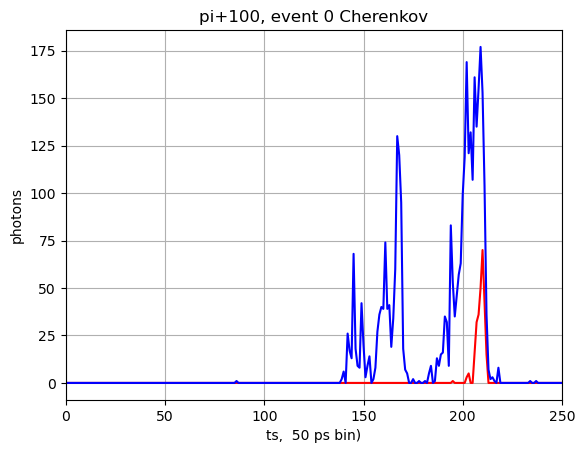

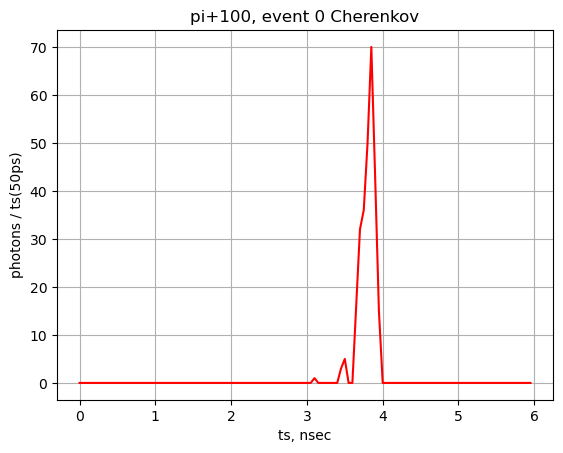

def plotDRShit...
ixmax 140   iymax 101   jmax  140101


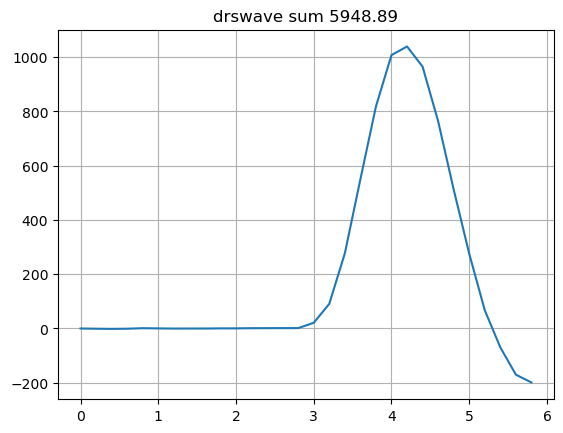

(def analyze2d)  2dmax pi+100, event 1 Cherenkov ix    140  iy   101 ph 158.00  en 3.40  sum 3057.00, 65.87 GeV
 2d k   0  (ix,iy)  (140, 101)  ph 158.00  en 3.40 GeV 
 2d k   1  (ix,iy)  (140,  94)  ph 153.00  en 3.30 GeV 
 2d k   2  (ix,iy)  (140,  93)  ph 144.00  en 3.10 GeV 
 2d k   3  (ix,iy)  (150,  94)  ph 121.00  en 2.61 GeV 
 2d k   4  (ix,iy)  (140,  92)  ph 109.00  en 2.35 GeV 
 2d k   5  (ix,iy)  (140,  91)  ph 82.00  en 1.77 GeV 
 2d k   6  (ix,iy)  (170, 100)  ph 81.00  en 1.75 GeV 
 2d k   7  (ix,iy)  (150,  92)  ph 75.00  en 1.62 GeV 
 2d k   8  (ix,iy)  (160,  94)  ph 61.00  en 1.31 GeV 
 2d k   9  (ix,iy)  (160, 101)  ph 59.00  en 1.27 GeV 
 2d k  10  (ix,iy)  (150,  93)  ph 55.00  en 1.19 GeV 
(def showerProfileT)  phsum= 158.0
def showerProfileT) phsum(max tower)  158.0   phsymAll  3035.0   All(GeV)  65.39538892480068


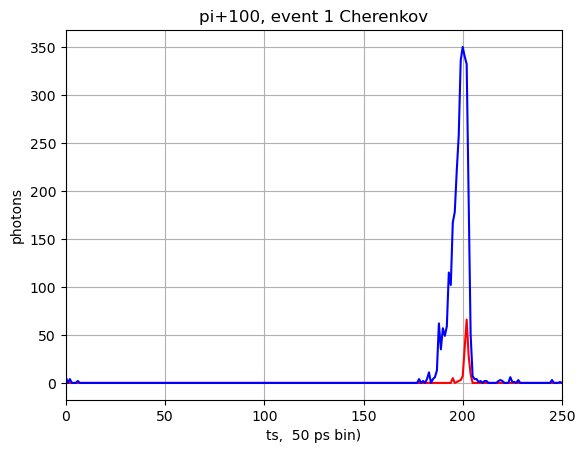

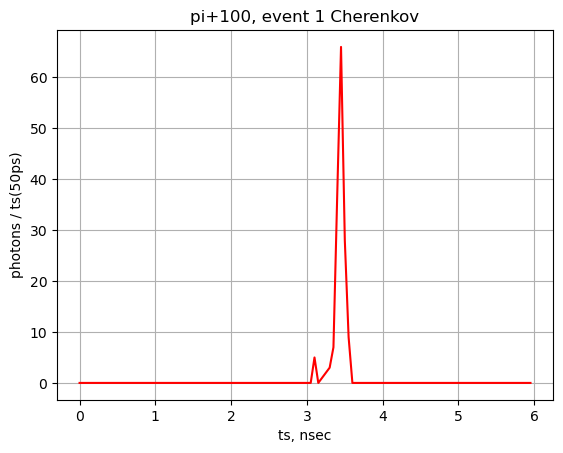

def plotDRShit...
ixmax 140   iymax 101   jmax  140101


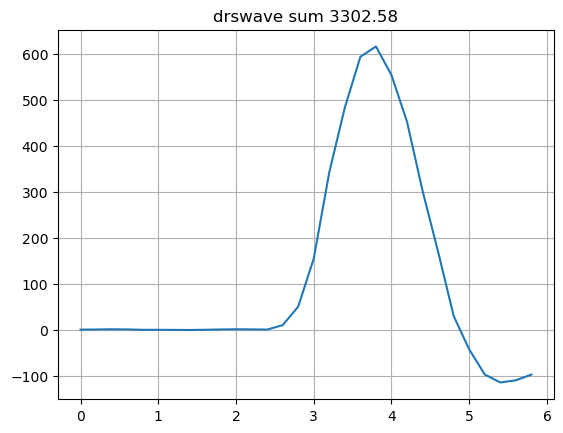

(def analyze2d)  2dmax pi+100, event 2 Cherenkov ix    160  iy    83 ph 337.00  en 7.26  sum 3386.00, 72.96 GeV
 2d k   0  (ix,iy)  (160,  83)  ph 337.00  en 7.26 GeV 
 2d k   1  (ix,iy)  (160,  84)  ph 264.00  en 5.69 GeV 
 2d k   2  (ix,iy)  (170,  80)  ph 245.00  en 5.28 GeV 
 2d k   3  (ix,iy)  (170,  90)  ph 210.00  en 4.52 GeV 
 2d k   4  (ix,iy)  (160,  82)  ph 165.00  en 3.56 GeV 
 2d k   5  (ix,iy)  (170,  70)  ph 150.00  en 3.23 GeV 
 2d k   6  (ix,iy)  (160,  91)  ph 111.00  en 2.39 GeV 
 2d k   7  (ix,iy)  (160,  70)  ph 91.00  en 1.96 GeV 
 2d k   8  (ix,iy)  (180,  70)  ph 85.00  en 1.83 GeV 
 2d k   9  (ix,iy)  (190,  60)  ph 72.00  en 1.55 GeV 
 2d k  10  (ix,iy)  (160,  81)  ph 65.00  en 1.40 GeV 
(def showerProfileT)  phsum= 337.0
def showerProfileT) phsum(max tower)  337.0   phsymAll  3367.0   All(GeV)  72.54901960784314


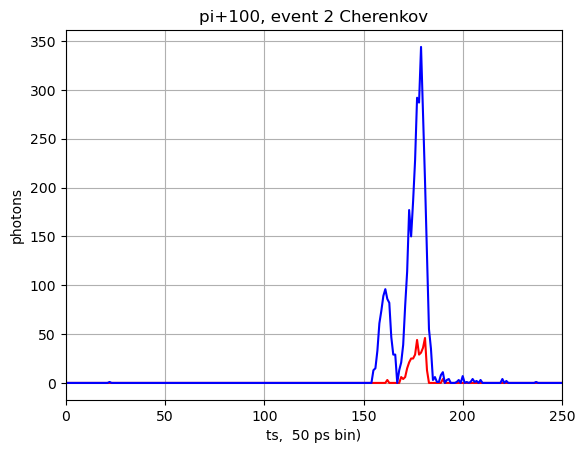

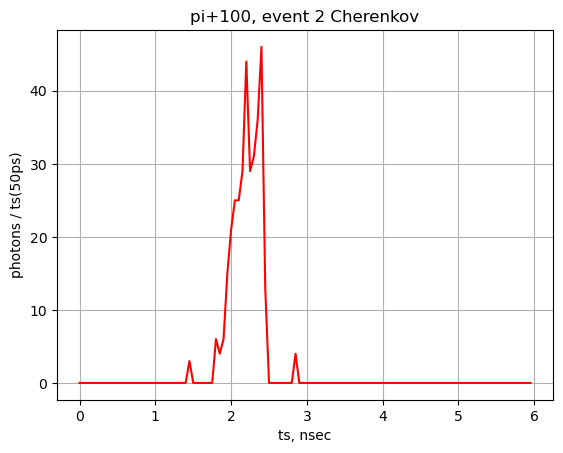

def plotDRShit...
ixmax 160   iymax 83   jmax  160083


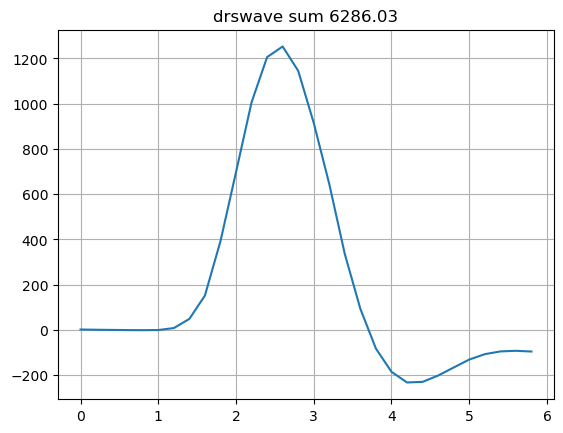

start processing key number  1 / 2    e+100
bookHistograms key= e+100
Name: tree Title: CaloX Tree
(def analyze2d)  2dmax e+100, event 0 Cherenkov ix    140  iy   103 ph 1102.00  en 23.74  sum 4691.00, 101.08 GeV
 2d k   0  (ix,iy)  (140, 103)  ph 1102.00  en 23.74 GeV 
 2d k   1  (ix,iy)  (140, 102)  ph 602.00  en 12.97 GeV 
 2d k   2  (ix,iy)  (140, 104)  ph 492.00  en 10.60 GeV 
 2d k   3  (ix,iy)  (150, 103)  ph 239.00  en 5.15 GeV 
 2d k   4  (ix,iy)  (140, 101)  ph 232.00  en 5.00 GeV 
 2d k   5  (ix,iy)  (150, 102)  ph 169.00  en 3.64 GeV 
 2d k   6  (ix,iy)  (140, 111)  ph 145.00  en 3.12 GeV 
 2d k   7  (ix,iy)  (150, 104)  ph 137.00  en 2.95 GeV 
 2d k   8  (ix,iy)  (150, 101)  ph 110.00  en 2.37 GeV 
 2d k   9  (ix,iy)  (140,  94)  ph 86.00  en 1.85 GeV 
 2d k  10  (ix,iy)  (130, 103)  ph 66.00  en 1.42 GeV 
(def showerProfileT)  phsum= 1102.0
def showerProfileT) phsum(max tower)  1102.0   phsymAll  4679.0   All(GeV)  100.81878905408317


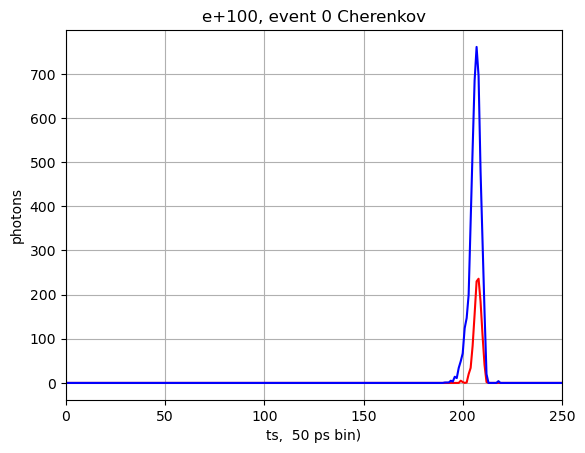

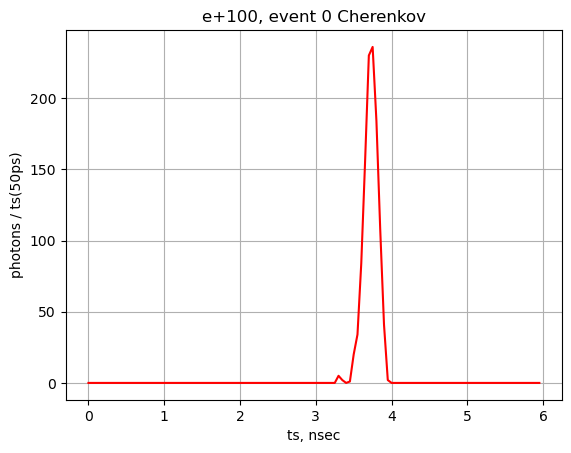

def plotDRShit...
ixmax 140   iymax 103   jmax  140103


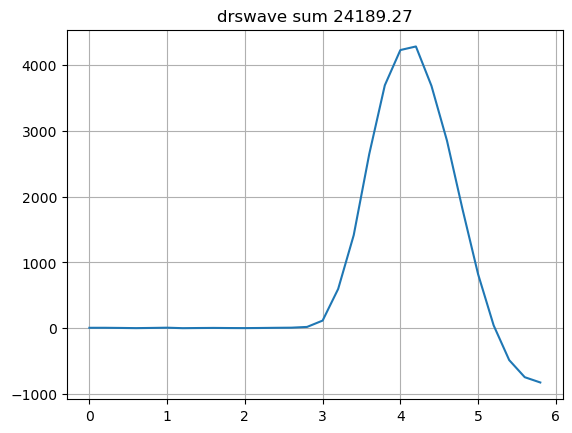

(def analyze2d)  2dmax e+100, event 1 Cherenkov ix    140  iy   102 ph 1175.00  en 25.32  sum 4591.00, 98.92 GeV
 2d k   0  (ix,iy)  (140, 102)  ph 1175.00  en 25.32 GeV 
 2d k   1  (ix,iy)  (140, 101)  ph 588.00  en 12.67 GeV 
 2d k   2  (ix,iy)  (140, 103)  ph 547.00  en 11.79 GeV 
 2d k   3  (ix,iy)  (130, 102)  ph 190.00  en 4.09 GeV 
 2d k   4  (ix,iy)  (140,  94)  ph 181.00  en 3.90 GeV 
 2d k   5  (ix,iy)  (130, 101)  ph 151.00  en 3.25 GeV 
 2d k   6  (ix,iy)  (140, 104)  ph 135.00  en 2.91 GeV 
 2d k   7  (ix,iy)  (130, 103)  ph 126.00  en 2.71 GeV 
 2d k   8  (ix,iy)  (130,  94)  ph 96.00  en 2.07 GeV 
 2d k   9  (ix,iy)  (140,  93)  ph 93.00  en 2.00 GeV 
 2d k  10  (ix,iy)  (150, 101)  ph 80.00  en 1.72 GeV 
(def showerProfileT)  phsum= 1174.0
def showerProfileT) phsum(max tower)  1174.0   phsymAll  4571.0   All(GeV)  98.49170437405732


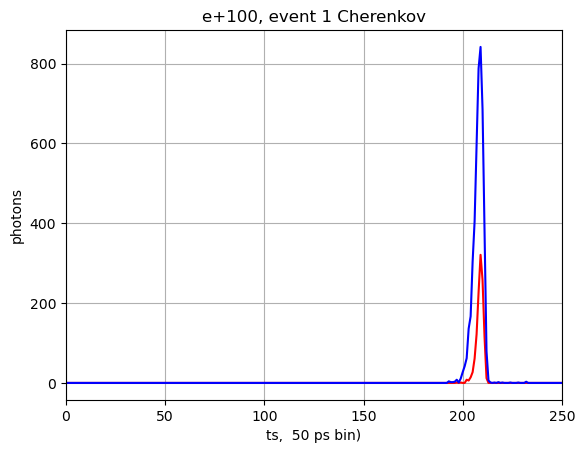

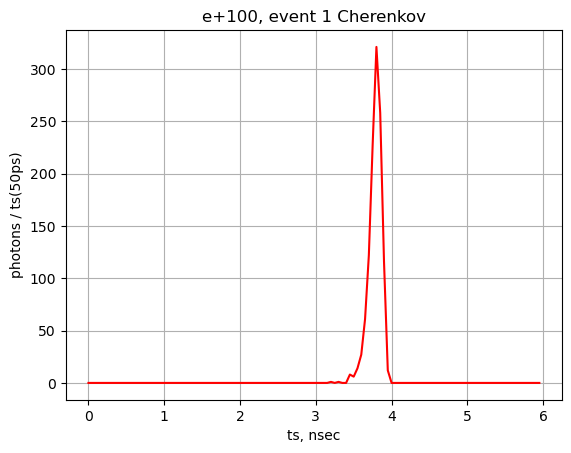

def plotDRShit...
ixmax 140   iymax 102   jmax  140102


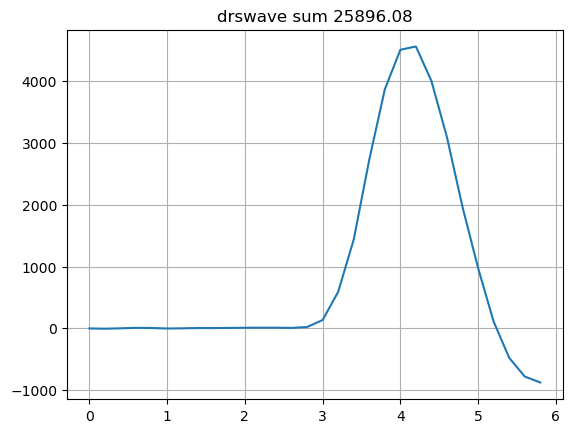

(def analyze2d)  2dmax e+100, event 2 Cherenkov ix    140  iy   101 ph 849.00  en 18.29  sum 4645.00, 100.09 GeV
 2d k   0  (ix,iy)  (140, 101)  ph 849.00  en 18.29 GeV 
 2d k   1  (ix,iy)  (140,  94)  ph 682.00  en 14.70 GeV 
 2d k   2  (ix,iy)  (140, 102)  ph 446.00  en 9.61 GeV 
 2d k   3  (ix,iy)  (140,  93)  ph 261.00  en 5.62 GeV 
 2d k   4  (ix,iy)  (150,  93)  ph 248.00  en 5.34 GeV 
 2d k   5  (ix,iy)  (150,  94)  ph 238.00  en 5.13 GeV 
 2d k   6  (ix,iy)  (150,  92)  ph 157.00  en 3.38 GeV 
 2d k   7  (ix,iy)  (150, 101)  ph 134.00  en 2.89 GeV 
 2d k   8  (ix,iy)  (140, 103)  ph 107.00  en 2.31 GeV 
 2d k   9  (ix,iy)  (140,  92)  ph 97.00  en 2.09 GeV 
 2d k  10  (ix,iy)  (130, 101)  ph 96.00  en 2.07 GeV 
(def showerProfileT)  phsum= 848.0
def showerProfileT) phsum(max tower)  848.0   phsymAll  4632.0   All(GeV)  99.80607627666451


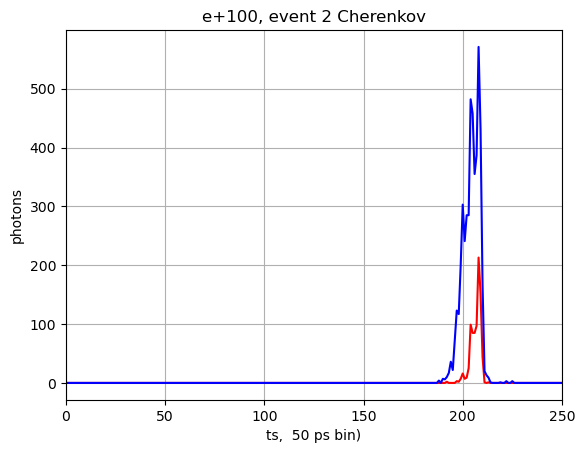

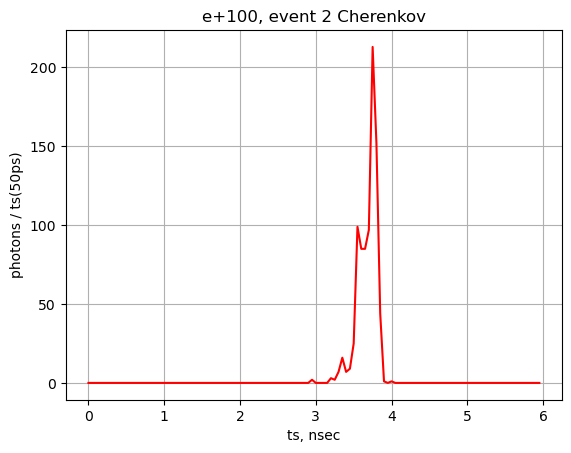

def plotDRShit...
ixmax 140   iymax 101   jmax  140101


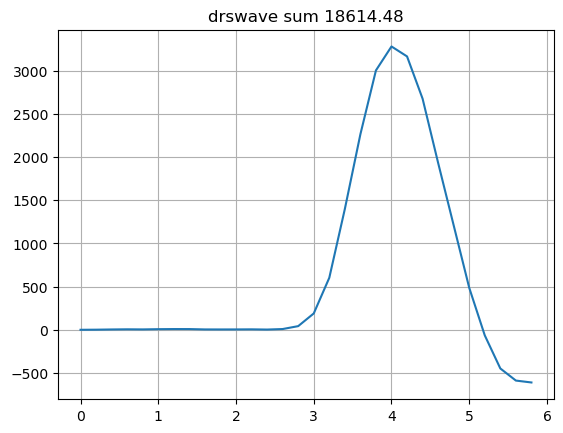

In [14]:
#  main program (2)

for ix, key in enumerate(keys):
    print("start processing key number ",ix,"/",len(keys),"  ",key)
    if ix==10:
        continue
    analyzeEvents(key,trees)


Info in <TCanvas::Print>: pdf file page1.pdf has been created


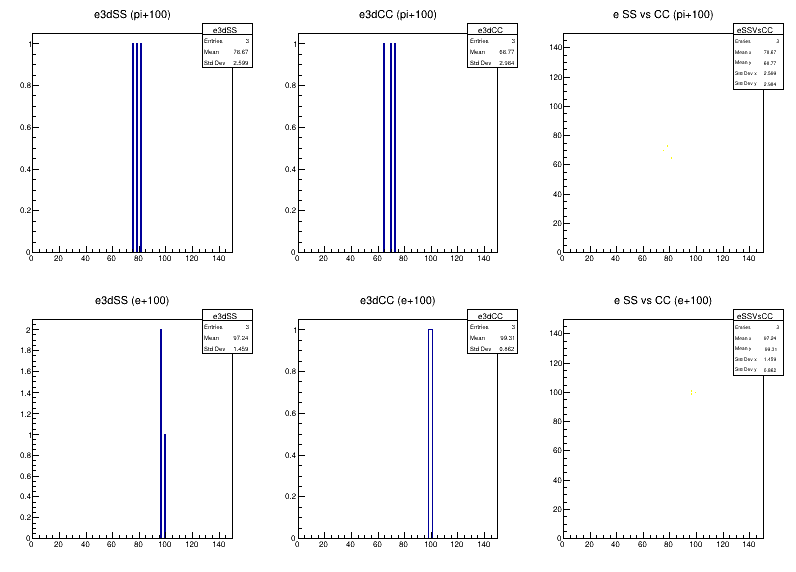

In [15]:

c1 = ROOT.TCanvas( 'c1', 'test', 200, 10, 800, 600)
c1.Divide(3,2)

k=0
for ix, key in enumerate(keys):
    k=k+1
    c1.cd(k)
    hname=key+"/"+"e3dSS"
    h=fout.Get(hname)
    h.Draw()
    k=k+1
    c1.cd(k)
    hname=key+"/"+"e3dCC"
    h=fout.Get(hname)
    h.Draw()
    k=k+1
    c1.cd(k)
    hname=key+"/"+"eSSVsCC"
    h=fout.Get(hname)
    h.Draw()

c1.Draw()
pdfname="page1.pdf"
c1.SaveAs(pdfname)

Info in <TCanvas::Print>: pdf file page2.pdf has been created


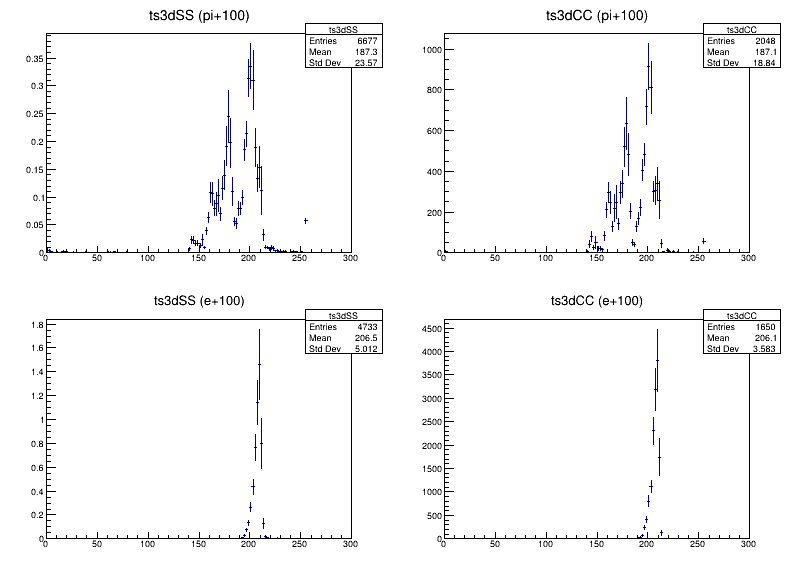

In [16]:
c1 = ROOT.TCanvas( 'c2', 'test', 200, 10, 800, 600)
c1.Divide(2,2)

k=0
for ix, key in enumerate(keys):
    k=k+1
    c1.cd(k)
    hname=key+"/"+"ts3dSS"
    h=fout.Get(hname)
    h.Draw()
    k=k+1
    c1.cd(k)
    hname=key+"/"+"ts3dCC"
    h=fout.Get(hname)
    h.Draw()

c1.Draw()
pdfname="page2.pdf"
c1.SaveAs(pdfname)

In [17]:
fout.Close()